In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import partial
from polyglot.tokenize import SentenceTokenizer, WordTokenizer
from polyglot.base import Sequence
import unicodedata
from collections import defaultdict, Counter
from lxml import html
from lxml.html.clean import clean_html
import Stemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from matplotlib_venn import venn2, venn2_circles
from sklearn.metrics import classification_report, accuracy_score

In [2]:
traindata = pd.read_csv("../data/train.csv")
testdata_all = pd.read_csv("../data/test.csv")
testlabels = pd.read_csv("../data/test_labels.csv")
testlabels = testlabels.loc[testlabels["toxic"] != -1]
testlabels.head()
testdata = pd.merge(testdata_all, testlabels, how="inner")

In [3]:
traindata[traindata['comment_text'] == ""]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate


In [4]:
list(traindata["comment_text"][:10])

["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
 "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
 '"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on r

In [5]:
word_tokenizer = WordTokenizer(locale="en")
stemmer = Stemmer.Stemmer("en")

def remove_accents(text):
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return text

# A simplest form of preprocessing.
def preprocess(text):
    text = remove_accents(text)
    text = text.lower()
    textlist = word_tokenizer.transform(Sequence(text)).tokens()
    textlist = list(filter(lambda x: x.isalpha(), textlist))
    return stemmer.stemWords(textlist)


In [6]:
# We first collect stopwords from our training dataset

__vocab = Counter()
for i in range(len(traindata)):
    __vocab.update(preprocess(traindata.iloc[i]['comment_text']))

Total words found: 122649
Most common word ('the', 496344)
200th Most common word ('our', 7011)


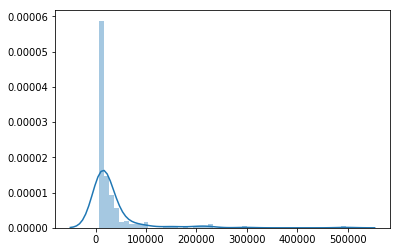

In [7]:
most_common_words = __vocab.most_common(200)
sns.distplot([x[1] for x in most_common_words])
print("Total words found: {}".format(len(__vocab)))
print("Most common word {}".format(most_common_words[0]))
print("200th Most common word {}".format(most_common_words[-1]))

## Also remove words which are one off, most proabably these are names / identifiers
__vocab = { word: __vocab[word] for word in __vocab if __vocab[word] > 5 }

In [8]:
## Manual observation of most_common_words; From manual observation it seems that the topmost 70
## common words can be considered as our stopwords
print("{}".format([x[0] for x in most_common_words[:70]]))

STOP_WORDS = [x[0] for x in most_common_words[:70]]
VOCABList = list(set(__vocab.keys()) - set(STOP_WORDS))
VOCAB = dict(zip(VOCABList, range(len(VOCABList))))
print("Total words in VOCAB {}".format(len(VOCAB)))

['the', 'to', 'of', 'and', 'a', 'you', 'i', 'is', 'that', 'in', 'it', 'for', 'be', 'this', 'not', 'on', 'as', 'have', 'articl', 'are', 'your', 'with', 'if', 'page', 'was', 'or', 'but', 'my', 'an', 'do', 'from', 'edit', 'by', 'at', 'me', 'about', 'wikipedia', 'so', 'use', 'talk', 'what', 'can', 'there', 'all', 'will', 'has', 'like', 'one', 'pleas', 'would', 'no', 'just', 'they', 'other', 'delet', 'he', 'ani', 'which', 'been', 'thank', 'sourc', 'should', 'more', 'we', 'see', 'some', 'think', 'who', 'here', 'make']
Total words in VOCAB 24998


In [9]:
## Modification of the preprocess function to account for STOPWORDS

def clear_html(text):
    ## Html cleaner will throw exception when an incorrect tag formation is detected
    ## a 'prompt' like symbol e.g.: '<- '
    try:
        text = clean_html(html.fromstring(text)).text()
    except Exception as e:
        pass
    return text

def preprocess(with_stemmer, text):
    text = remove_accents(clear_html(text))
    text = text.lower()
    textlist = word_tokenizer.transform(Sequence(text)).tokens()
    textlist = list(filter(lambda x: x.isalpha() and not(x in STOP_WORDS), textlist))
    return stemmer.stemWords(textlist) if with_stemmer else textlist

In [10]:
def preprocessjoin(with_stemmer, text):
    try:
        return " ".join(preprocess(with_stemmer, text))
    except Exception as e:
        print(text)

traindata['PREPROCESSED'] = traindata['comment_text'].apply(partial(preprocessjoin, True))
testdata['PREPROCESSED'] = testdata['comment_text'].apply(partial(preprocessjoin, True))
traindata['PREPROCESSED_NOSTEM'] = traindata['comment_text'].apply(partial(preprocessjoin, False))
testdata['PREPROCESSED_NOSTEM'] = testdata['comment_text'].apply(partial(preprocessjoin, False))

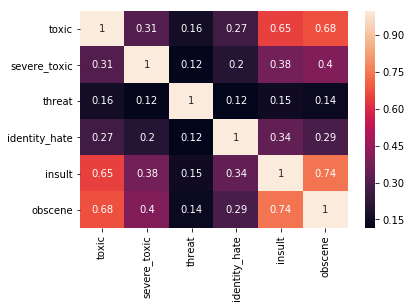

In [11]:
COLUMNS = ['toxic', 'severe_toxic', 'threat', 'identity_hate', 'insult', 'obscene']
sns.heatmap(traindata[COLUMNS].corr(), annot=True)
# Obscene and insult are fairly positively correlated
def combine_two_cols(col1, col2, row):
    return 1 if (row[col1] == 1 or row[col2] == 1) else 0
traindata["insult_obscene"] = traindata.apply(partial(
                                                  combine_two_cols, "insult", "obscene"),
                                              axis=1)
testdata["insult_obscene"] = testdata.apply(partial(
                                                  combine_two_cols, "insult", "obscene"),
                                              axis=1)
traindata.head()
COLUMNS.remove("insult")
COLUMNS.remove("obscene")
COLUMNS.append("insult_obscene")

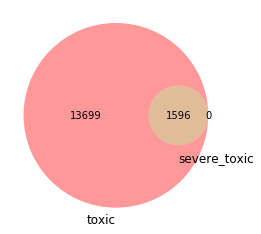

In [12]:
# Display toxic and severe toxic using venn diagrams; ONLY lets comapre for true values
def venncompare(col1, col2):
    col1set = set(traindata.apply(
                       lambda r: ("{}_{}".format(r["id"], r[col1])
                                  if r[col1] == 1 else "DONTCARE"), axis=1))
    col2set = set(traindata.apply(
                            lambda r: ("{}_{}".format(r["id"], r[col2])
                                       if r[col2] == 1 else "DONTCARE"), axis=1))
    venn2([col1set, col2set], set_labels=(col1, col2))
venncompare("toxic", "severe_toxic")
COLUMNS.remove("severe_toxic")

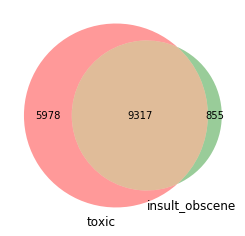

In [13]:
venncompare("toxic", "insult_obscene")
traindata["toxic_new"] = traindata.apply(partial(
                                             combine_two_cols, "insult_obscene", "toxic"),
                                         axis=1)
testdata["toxic_new"] = testdata.apply(partial(
                                             combine_two_cols, "insult_obscene", "toxic"),
                                         axis=1)
traindata.head()
COLUMNS.remove("insult_obscene")
COLUMNS.remove("toxic")
COLUMNS.append("toxic_new")

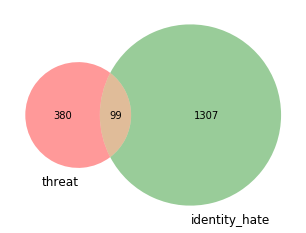

In [14]:
venncompare("threat", "identity_hate")

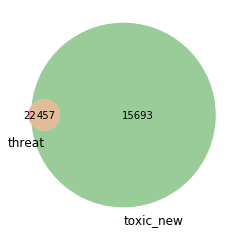

In [15]:
venncompare("threat", "toxic_new")

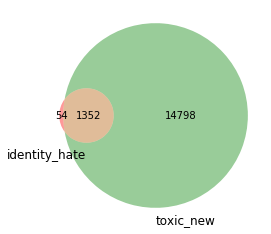

In [16]:
venncompare("identity_hate", "toxic_new")

In [17]:
traindata["toxic_all"] = traindata.apply(partial(
                                             combine_two_cols, "identity_hate", "toxic_new"),
                                         axis=1)
traindata["toxic_all"] = traindata.apply(partial(
                                             combine_two_cols, "threat", "toxic_all"),
                                         axis=1)
testdata["toxic_all"] = testdata.apply(partial(
                                             combine_two_cols, "identity_hate", "toxic_new"),
                                         axis=1)
testdata["toxic_all"] = testdata.apply(partial(
                                             combine_two_cols, "threat", "toxic_all"),
                                         axis=1)

In [18]:
## Simple Count LR over the vocab
vectorizer = CountVectorizer(vocabulary=VOCAB)
X = vectorizer.fit_transform(traindata['PREPROCESSED'])
lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=600)
lr.fit(X, traindata["toxic_all"])
Xtest = vectorizer.transform(testdata['PREPROCESSED'])
print(classification_report(testdata["toxic_all"], lr.predict(Xtest)))

/home/synerzip/python/feedbackcontent/.env/lib/python3.5/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.97      0.95      0.96     57735
           1       0.60      0.69      0.65      6243

   micro avg       0.93      0.93      0.93     63978
   macro avg       0.78      0.82      0.80     63978
weighted avg       0.93      0.93      0.93     63978



In [19]:
vectorizer = TfidfVectorizer(vocabulary=VOCAB)
X = vectorizer.fit_transform(traindata['PREPROCESSED'])
lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=500)
lr.fit(X, traindata["toxic_all"])
Xtest = vectorizer.transform(testdata['PREPROCESSED'])
print(classification_report(testdata["toxic_all"], lr.predict(Xtest)))
print(classification_report(traindata["toxic_all"], lr.predict(X)))
accuracy_score(traindata["toxic_all"], lr.predict(X))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     57735
           1       0.63      0.74      0.68      6243

   micro avg       0.93      0.93      0.93     63978
   macro avg       0.80      0.85      0.82     63978
weighted avg       0.94      0.93      0.94     63978

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    143346
           1       0.94      0.67      0.78     16225

   micro avg       0.96      0.96      0.96    159571
   macro avg       0.95      0.83      0.88    159571
weighted avg       0.96      0.96      0.96    159571



0.961904105382557

In [20]:
vectorizer = TfidfVectorizer(vocabulary=VOCAB, ngram_range=(1,3), analyzer='word', max_features=10000)
X = vectorizer.fit_transform(traindata['PREPROCESSED'])
lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=500)
lr.fit(X, traindata["toxic_all"])
Xtest = vectorizer.transform(testdata['PREPROCESSED'])
print(classification_report(testdata["toxic_all"], lr.predict(Xtest)))
print(classification_report(traindata["toxic_all"], lr.predict(X)))
accuracy_score(traindata["toxic_all"], lr.predict(X))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     57735
           1       0.63      0.74      0.68      6243

   micro avg       0.93      0.93      0.93     63978
   macro avg       0.80      0.85      0.82     63978
weighted avg       0.94      0.93      0.94     63978

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    143346
           1       0.94      0.67      0.78     16225

   micro avg       0.96      0.96      0.96    159571
   macro avg       0.95      0.83      0.88    159571
weighted avg       0.96      0.96      0.96    159571



0.961904105382557

In [21]:
vectorizer = TfidfVectorizer(vocabulary=VOCAB, ngram_range=(1,3), analyzer='word', max_features=10000)
X = vectorizer.fit_transform(traindata['PREPROCESSED_NOSTEM'])
lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=500)
lr.fit(X, traindata["toxic_all"])
Xtest = vectorizer.transform(testdata['PREPROCESSED_NOSTEM'])
print(classification_report(testdata["toxic_all"], lr.predict(Xtest)))
print(classification_report(traindata["toxic_all"], lr.predict(X)))
accuracy_score(traindata["toxic_all"], lr.predict(X))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     57735
           1       0.62      0.64      0.63      6243

   micro avg       0.93      0.93      0.93     63978
   macro avg       0.79      0.80      0.80     63978
weighted avg       0.93      0.93      0.93     63978

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    143346
           1       0.92      0.59      0.72     16225

   micro avg       0.95      0.95      0.95    159571
   macro avg       0.94      0.79      0.85    159571
weighted avg       0.95      0.95      0.95    159571



0.9529864449054026

In [22]:
# Lets select one with better Recall

vectorizer = TfidfVectorizer(vocabulary=VOCAB, analyzer='word', max_features=10000)
X = vectorizer.fit_transform(traindata['PREPROCESSED'])
lr = LogisticRegression(random_state=42, solver='liblinear', max_iter=500)
lr.fit(X, traindata["toxic_all"])
Xtest = vectorizer.transform(testdata['PREPROCESSED'])
print(classification_report(testdata["toxic_all"], lr.predict(Xtest)))
print(classification_report(traindata["toxic_all"], lr.predict(X)))
accuracy_score(traindata["toxic_all"], lr.predict(X))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     57735
           1       0.63      0.74      0.68      6243

   micro avg       0.93      0.93      0.93     63978
   macro avg       0.80      0.85      0.82     63978
weighted avg       0.94      0.93      0.94     63978

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    143346
           1       0.94      0.67      0.78     16225

   micro avg       0.96      0.96      0.96    159571
   macro avg       0.95      0.83      0.88    159571
weighted avg       0.96      0.96      0.96    159571



0.961904105382557

In [47]:
model = {
    "stop_words": STOP_WORDS,
    "vocab": np.asarray(list(VOCAB.keys())),
    "intercept": lr.intercept_,
    "idf_": vectorizer.idf_,
    "lr": lr.coef_.flatten(),
    "vectorizer": [vectorizer]
}
# print(model)
np.savez("../feedbackcontent/model/baseline", **model)